In [95]:
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import graphviz as gr
import numpy as np
import seaborn as sns
from sklearn.preprocessing import scale, minmax_scale
import xarray as xr

print(f"Running on PyMC v{pm.__version__}")
az.style.use("arviz-darkgrid")

Running on PyMC v5.0.1


# 1.

From the Howell1 dataset, consider only the people younger than 13 years
old. Estimate the causal association between age and weight. Assume that
age influences weight through two paths. First, age influences height, and
height influences weight. Second, age directly influences weight through agerelated changes in muscle growth and body proportions.

In [6]:
data = pd.read_csv('../Data/Howell1.csv', delimiter=';')
data = data[data['age']<13]
data.describe()

height      weight         age        male
count  146.000000  146.000000  146.000000  146.000000
mean    98.810729   14.693328    5.401370    0.486301
std     21.489527    5.722741    3.824657    0.501533
min     53.975000    4.252425    0.000000    0.000000
25%     84.455000   10.829509    2.000000    0.000000
50%     98.844100   13.792032    5.000000    0.000000
75%    114.300000   18.335039    8.000000    1.000000
max    147.955000   32.488527   12.000000    1.000000

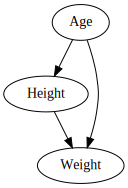

In [7]:
G = gr.Digraph()
G.edge('Age', 'Height')
G.edge('Height', 'Weight')
G.edge('Age', 'Weight')
G

In [123]:
def dgp(age: int):
    height = 60 + age*8 + np.random.normal(0,2)
    weight = 0.2*height + 2*age + np.random.normal(0,4)
    # weight = 3 + 0.4*age + 2*age = 3 + 2.4*age
    return height, weight

dgp(12)

(158.42168015536024, 48.629740711430884)

In [124]:
ages = range(1,13)
N = 10
gen_data = []
for age in ages:
    for n in range(N):
        h, w = dgp(age)
        d = {
            'age': age,
            'height': h,
            'weight': w,
        }
        gen_data.append(d)
gen_data = pd.DataFrame(gen_data)
gen_data

age      height     weight
0      1   62.681806  15.305228
1      1   67.496956  17.628645
2      1   69.177777  17.684243
3      1   68.417891  15.169105
4      1   68.126831  16.057715
..   ...         ...        ...
115   12  154.921833  46.309819
116   12  156.675439  55.615704
117   12  157.761672  66.901311
118   12  157.171010  56.089306
119   12  154.933171  58.432640

[120 rows x 3 columns]

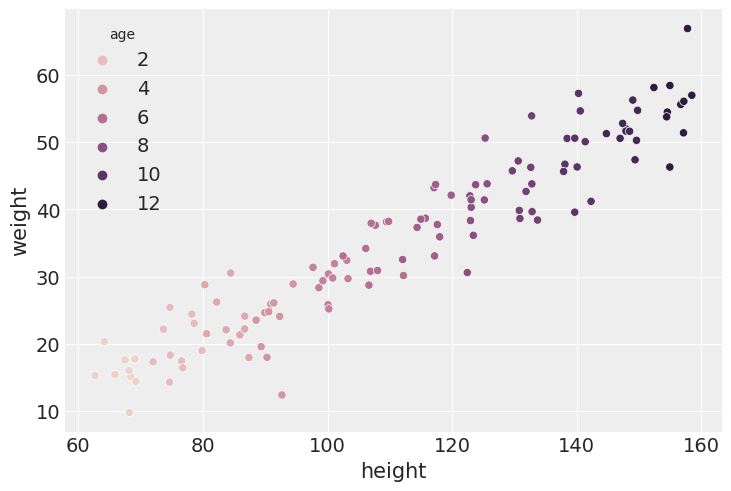

In [125]:
sns.scatterplot(data=gen_data, x='height', y='weight', hue='age');

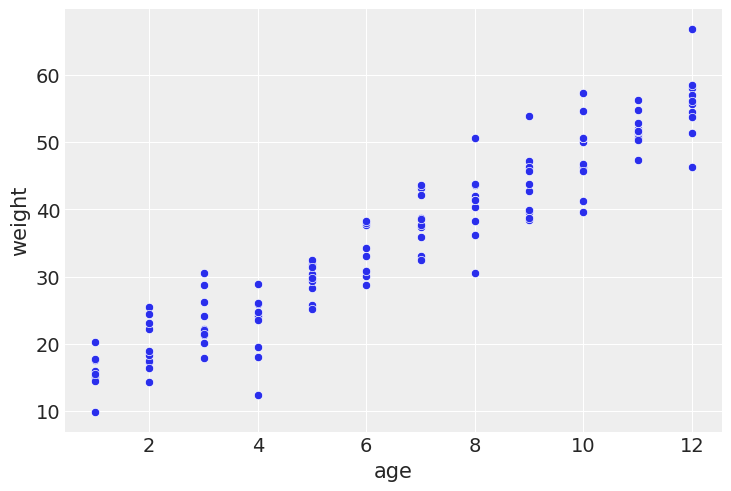

In [126]:
sns.scatterplot(data=gen_data, x='age', y='weight');

# 2

Use a linear regression to estimate the total causal effect of each year of growth on weight

In [127]:
data = pd.read_csv('../Data/Howell1.csv', delimiter=';')
data = data[data['age']<13]
# data.loc[:, ['height', 'weight', 'age']] = scale(data.loc[:, ['height', 'weight', 'age']] )
data

height     weight   age  male
18   121.920  19.617854  12.0     1
19   105.410  13.947954   8.0     0
20    86.360  10.489315   6.5     0
24   109.220  15.989118   7.0     0
30   114.300  17.860185  11.0     1
..       ...        ...   ...   ...
531   87.630  10.659412   6.0     0
535  114.935  17.519991   7.0     1
536   67.945   7.229122   1.0     0
538   76.835   8.022908   1.0     1
542   71.120   8.051258   0.0     1

[146 rows x 4 columns]

In [139]:
with pm.Model() as model:
    age_data = pm.ConstantData(name='age_data', value=gen_data['age'])
    weight_data = pm.ConstantData(name='weight_data',value=gen_data['weight'])
    
    beta_w_a = pm.Uniform('beta_w_a',0, 10)
    alpha_w = pm.Uniform('alpha_w', 1, 20)
    sigma_w = pm.Uniform('sigma_w',0, 10)

    mu_w = pm.Deterministic('mu_w', alpha_w + beta_w_a*age_data)
    weight = pm.Normal('weight', mu_w, sigma_w, observed=weight_data)
    
model

beta_w_a ~ U(0, 10)
 alpha_w ~ U(1, 20)
 sigma_w ~ U(0, 10)
    mu_w ~ Deterministic(f(alpha_w, beta_w_a))
  weight ~ N(mu_w, sigma_w)

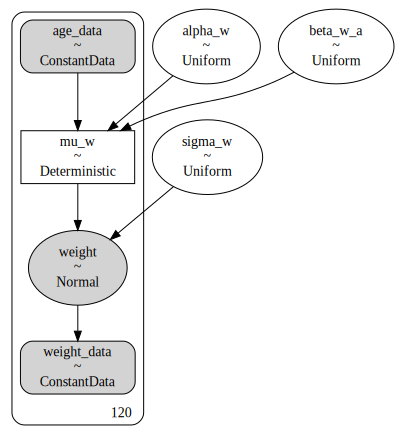

In [140]:
pm.model_to_graphviz(model)

Sampling: [alpha_w, beta_w_a, sigma_w, weight]


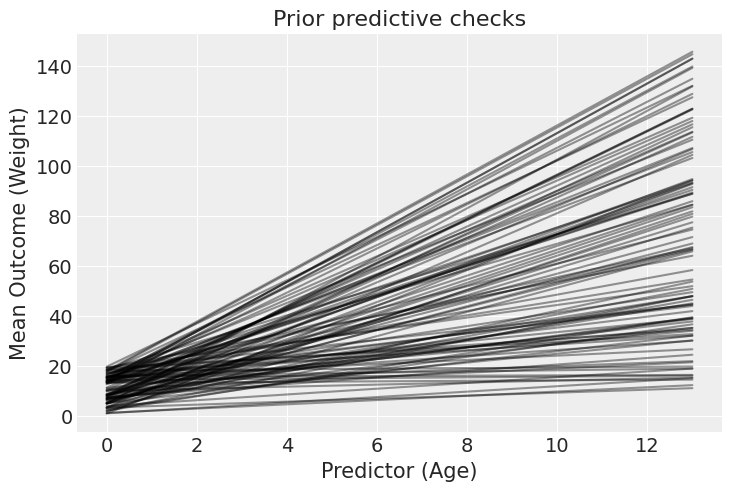

In [141]:
with model:
    samples = pm.sample_prior_predictive(samples=100)
    
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(0, 13, 100), dims=["plot_dim"])
prior = samples.prior
y = prior["alpha_w"] + prior["beta_w_a"] * x
ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)
ax.set_xlabel("Predictor (Age)")
ax.set_ylabel("Mean Outcome (Weight)")
ax.set_title("Prior predictive checks");

In [142]:
with model:
    samples = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_w_a, alpha_w, sigma_w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


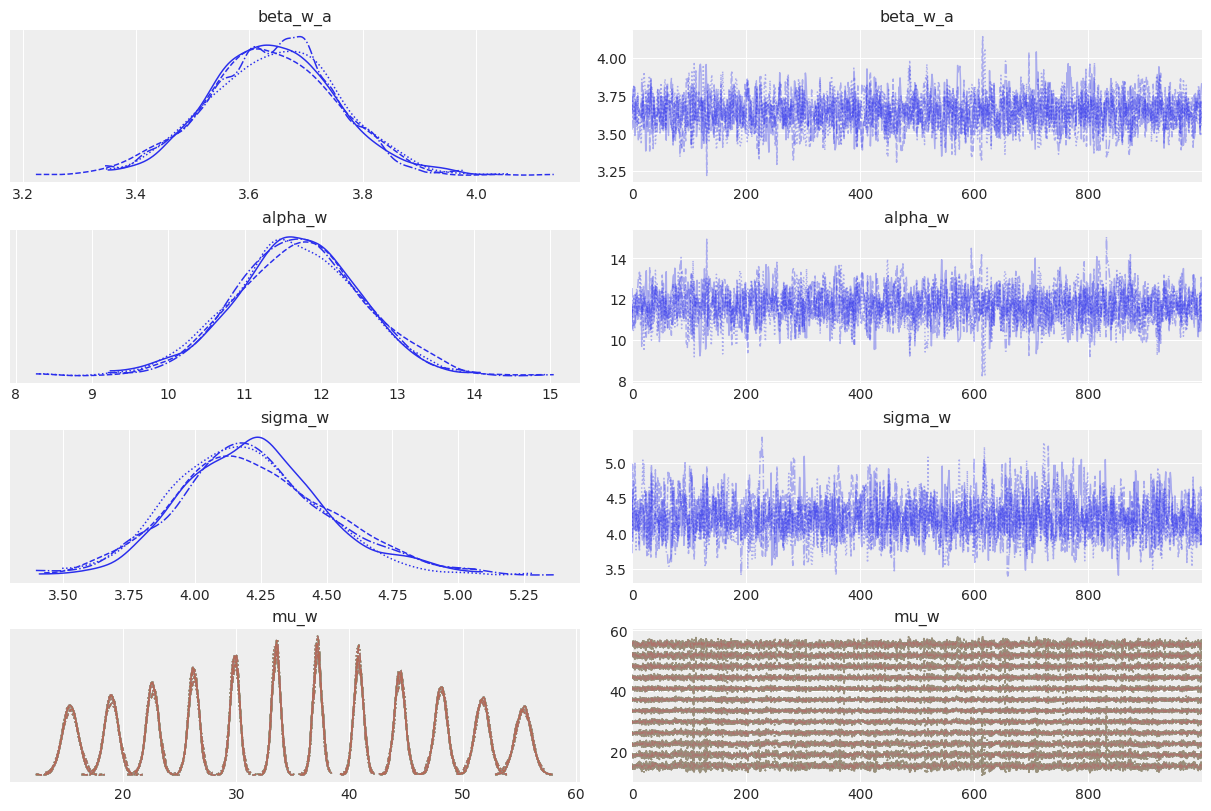

In [143]:
az.plot_trace(samples);

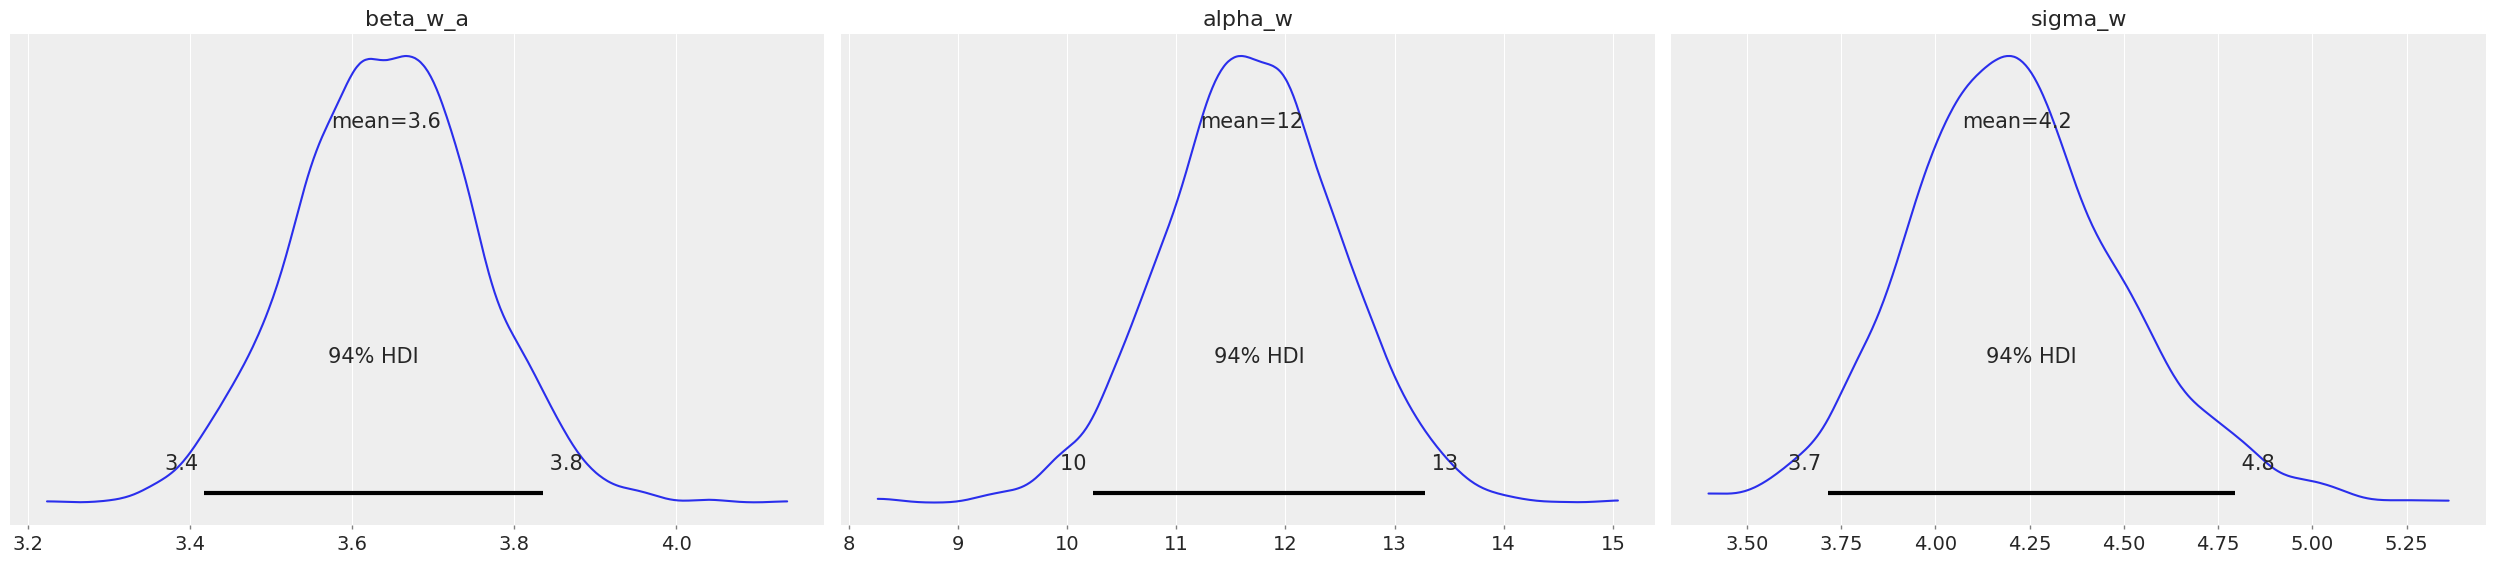

In [144]:
az.plot_posterior(samples, var_names=['beta_w_a', 'alpha_w', 'sigma_w']);

In [145]:
#Simulating lines from prior
with model:
    pm.sample_posterior_predictive(samples, extend_inferencedata=True)

Sampling: [weight]


<AxesSubplot: xlabel='weight / weight'>

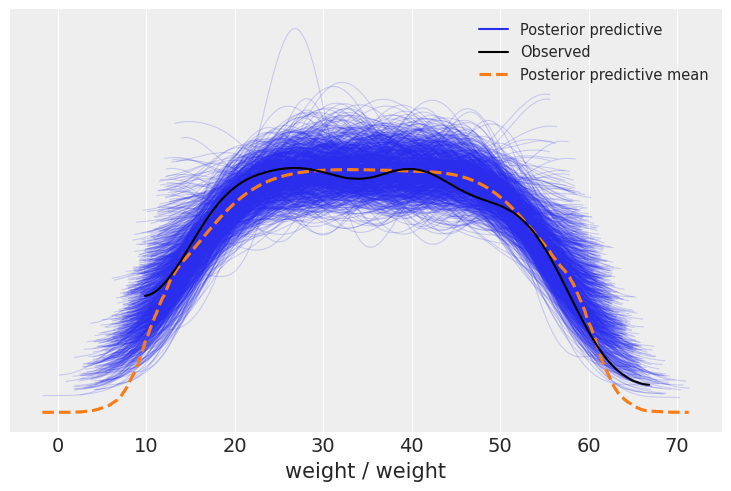

In [146]:
az.plot_ppc(samples, num_pp_samples=1000)

In [147]:
az.summary(samples, var_names=['beta_w_a', 'alpha_w', 'sigma_w'], kind='stats')

mean     sd  hdi_3%  hdi_97%
beta_w_a   3.641  0.111   3.417    3.836
alpha_w   11.689  0.812  10.237   13.281
sigma_w    4.216  0.285   3.714    4.795

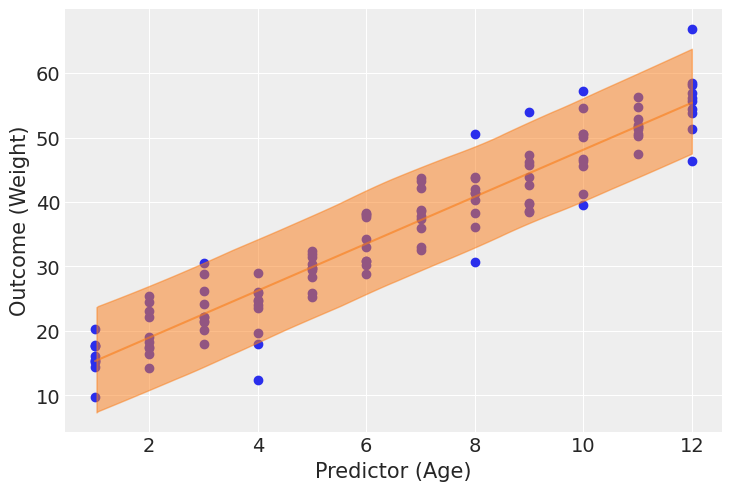

In [150]:
post = samples.posterior
mu_w = post["alpha_w"] + post["beta_w_a"] * xr.DataArray(gen_data['age'], dims=["obs_id"])

_, ax = plt.subplots()

ax.plot(
    gen_data['age'], mu_w.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6
)
ax.scatter(gen_data['age'], samples.observed_data["weight"])
az.plot_hdi(gen_data['age'], samples.posterior_predictive["weight"])
ax.set_xlabel("Predictor (Age)")
ax.set_ylabel("Outcome (Weight)");

It's a bit weird because the results do not agree with simulated parameters, also I didn't scale the values, but didn't seem to matter much. Will do the same on the real data.

In [151]:
with pm.Model() as model:
    age_data = pm.ConstantData(name='age_data', value=data['age'])
    weight_data = pm.ConstantData(name='weight_data',value=data['weight'])
    
    beta_w_a = pm.Uniform('beta_w_a',0, 10)
    alpha_w = pm.Uniform('alpha_w', 1, 20)
    sigma_w = pm.Uniform('sigma_w',0, 10)

    mu_w = pm.Deterministic('mu_w', alpha_w + beta_w_a*age_data)
    weight = pm.Normal('weight', mu_w, sigma_w, observed=weight_data)
    
model

beta_w_a ~ U(0, 10)
 alpha_w ~ U(1, 20)
 sigma_w ~ U(0, 10)
    mu_w ~ Deterministic(f(alpha_w, beta_w_a))
  weight ~ N(mu_w, sigma_w)

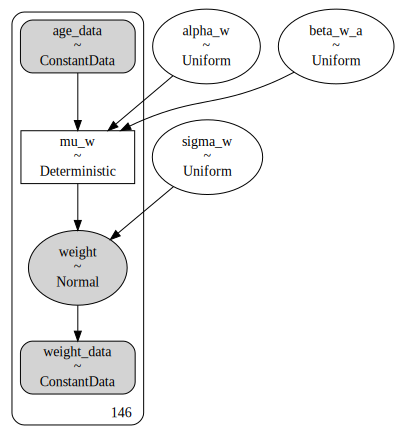

In [152]:
pm.model_to_graphviz(model)

Sampling: [alpha_w, beta_w_a, sigma_w, weight]


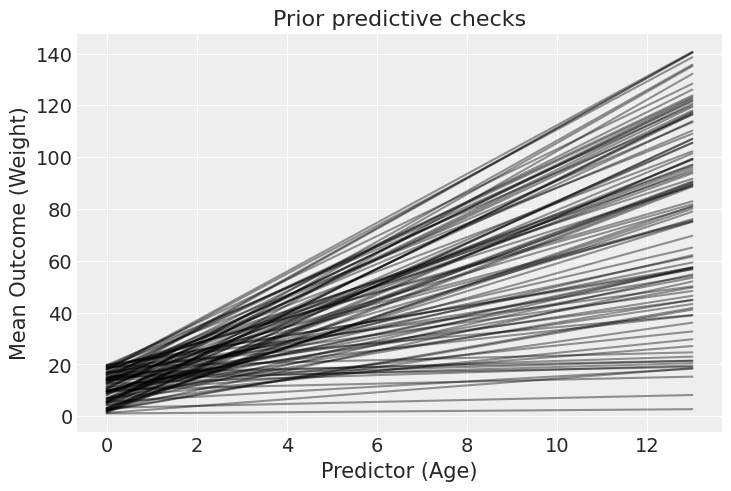

In [153]:
with model:
    samples = pm.sample_prior_predictive(samples=100)
    
_, ax = plt.subplots()

x = xr.DataArray(np.linspace(0, 13, 100), dims=["plot_dim"])
prior = samples.prior
y = prior["alpha_w"] + prior["beta_w_a"] * x
ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)
ax.set_xlabel("Predictor (Age)")
ax.set_ylabel("Mean Outcome (Weight)")
ax.set_title("Prior predictive checks");

In [154]:
with model:
    samples = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_w_a, alpha_w, sigma_w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


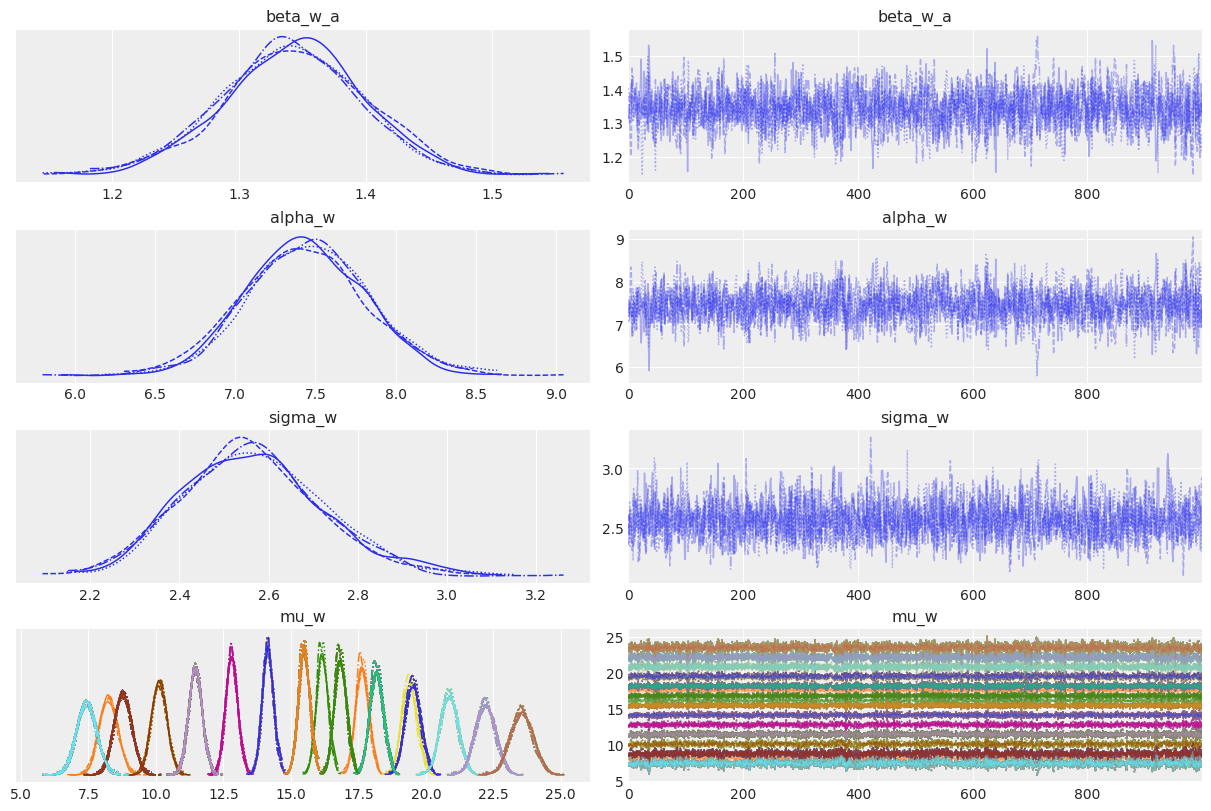

In [155]:
az.plot_trace(samples);

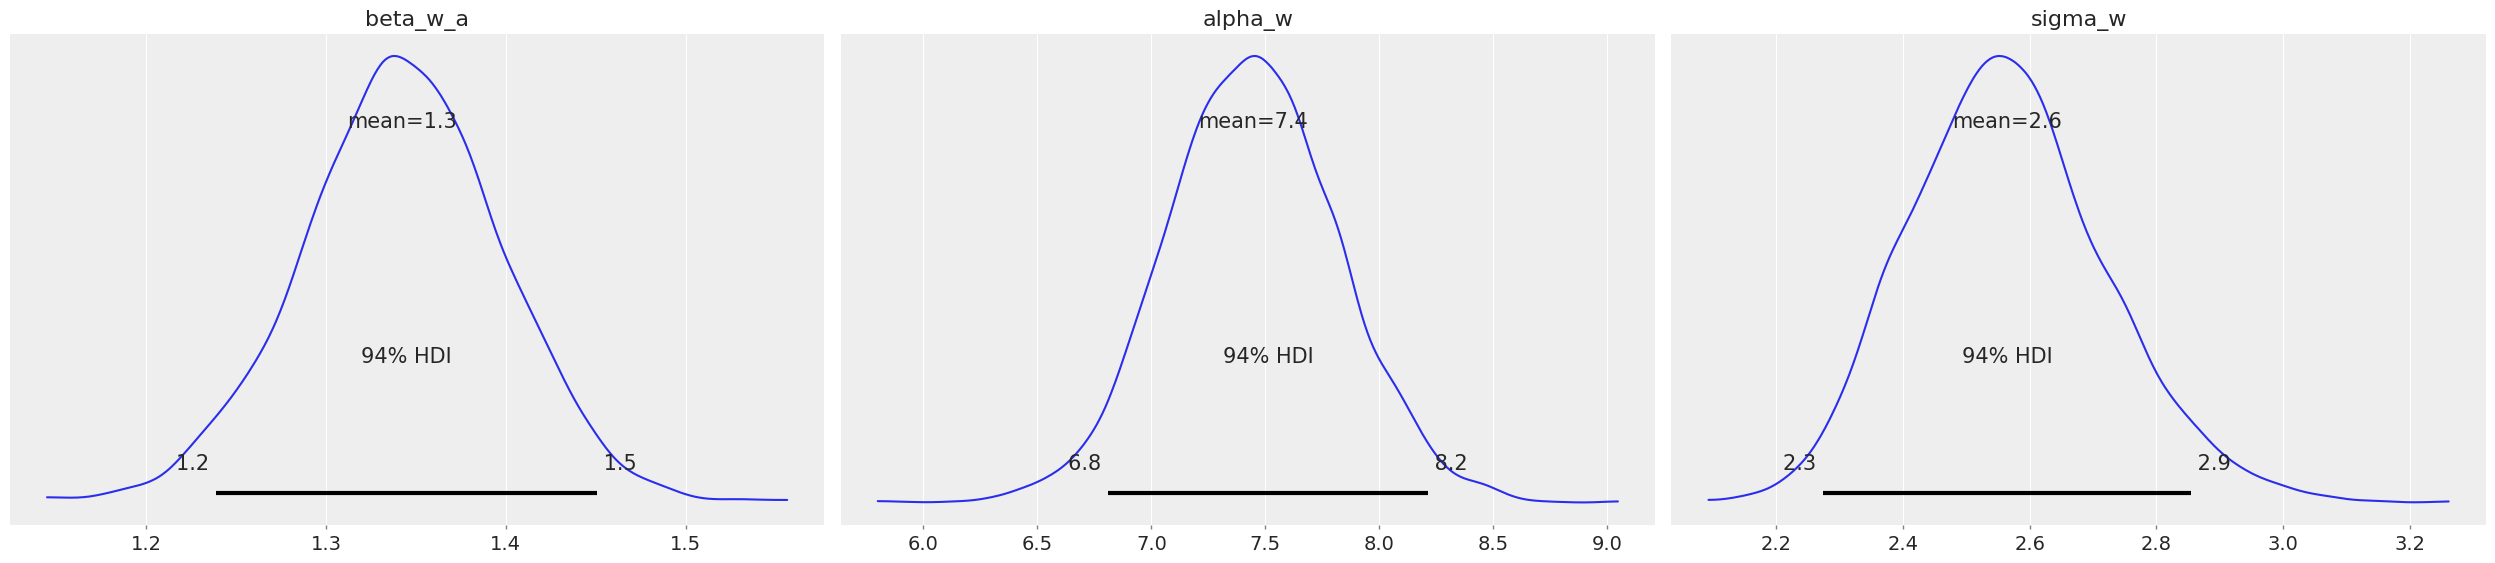

In [156]:
az.plot_posterior(samples, var_names=['beta_w_a', 'alpha_w', 'sigma_w']);

In [157]:
#Simulating lines from prior
with model:
    pm.sample_posterior_predictive(samples, extend_inferencedata=True)

Sampling: [weight]


<AxesSubplot: xlabel='weight / weight'>

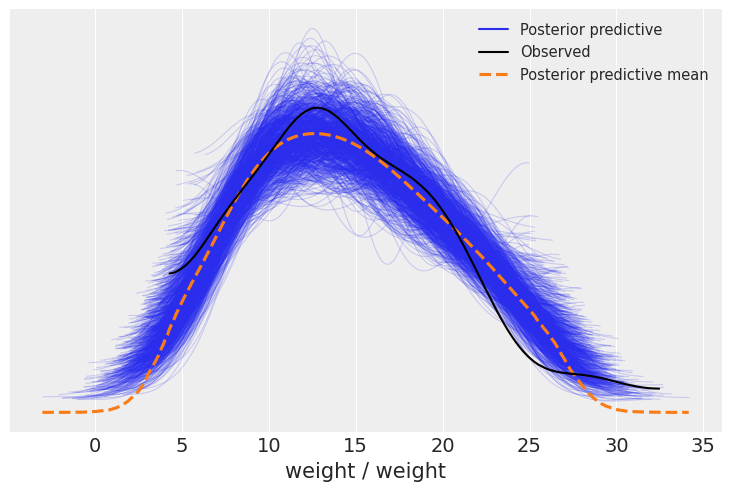

In [158]:
az.plot_ppc(samples, num_pp_samples=1000)

In [159]:
az.summary(samples, var_names=['beta_w_a', 'alpha_w', 'sigma_w'], kind='stats')

mean     sd  hdi_3%  hdi_97%
beta_w_a  1.342  0.056   1.239    1.451
alpha_w   7.446  0.376   6.808    8.216
sigma_w   2.564  0.156   2.274    2.854

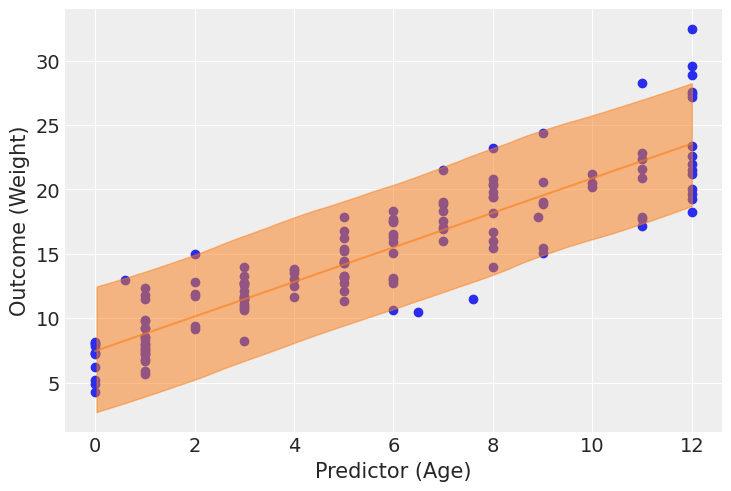

In [162]:
post = samples.posterior
mu_w = post["alpha_w"] + post["beta_w_a"] * xr.DataArray(data['age'], dims=["obs_id"])

_, ax = plt.subplots()

ax.plot(
    data['age'], mu_w.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6
)
ax.scatter(data['age'], samples.observed_data["weight"])
az.plot_hdi(data['age'], samples.posterior_predictive["weight"])
ax.set_xlabel("Predictor (Age)")
ax.set_ylabel("Outcome (Weight)");

# 3

Now suppose the causal association between age and weight might be different for boys and girls. Use a single linear regression, with a categorical
variable for sex, to estimate the total causal effect of age on weight separately
for boys and girls. How do girls and boys differ? Provide one or more posterior contrasts as a summarym

In [217]:
data['male'] = pd.Categorical(data['male'])

In [331]:
with pm.Model() as model:
    age_data = pm.ConstantData(name='age_data', value=data['age'], dims='samples')
    weight_data = pm.ConstantData(name='weight_data',value=data['weight'],  dims='samples')
    
    beta_w_a = pm.Uniform('beta_w_a',0, 10, shape = data['male'].cat.categories.size)
    alpha_w = pm.Uniform('alpha_w', 1, 20, shape = data['male'].cat.categories.size)
    sigma_w = pm.Uniform('sigma_w',0, 10)

    mu_w = alpha_w[data['male']] + beta_w_a[data['male']]*age_data
    weight = pm.Normal('weight', mu_w, sigma_w, observed=weight_data, dims='samples')
    
model

beta_w_a ~ U(0, 10)
 alpha_w ~ U(1, 20)
 sigma_w ~ U(0, 10)
  weight ~ N(f(alpha_w, beta_w_a), sigma_w)

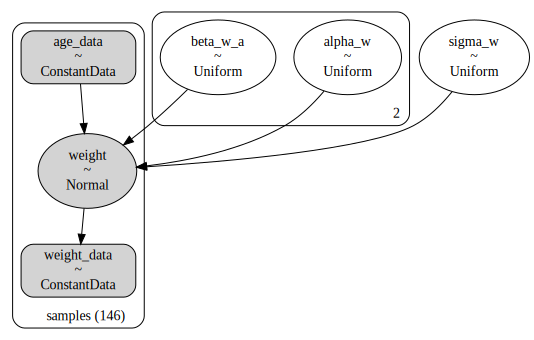

In [297]:
pm.model_to_graphviz(model)

Sampling: [alpha_w, beta_w_a, sigma_w, weight]


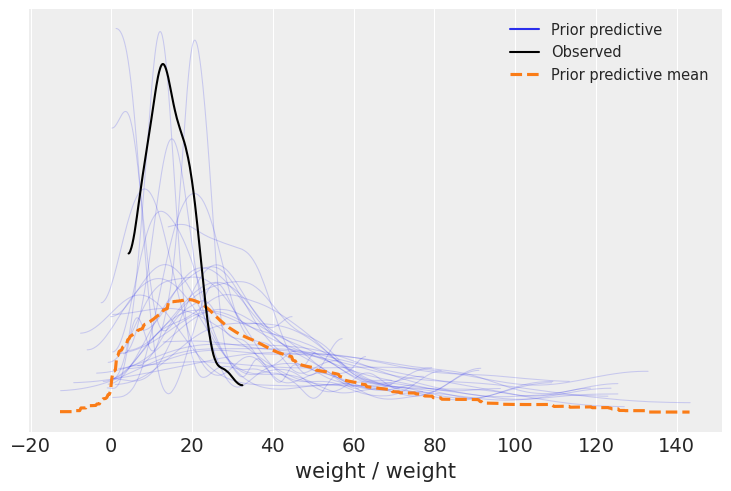

In [277]:
with model:
    samples = pm.sample_prior_predictive(samples=100)
    
az.plot_ppc(samples, group='prior', num_pp_samples=30);

In [278]:
with model:
    samples = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_w_a, alpha_w, sigma_w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


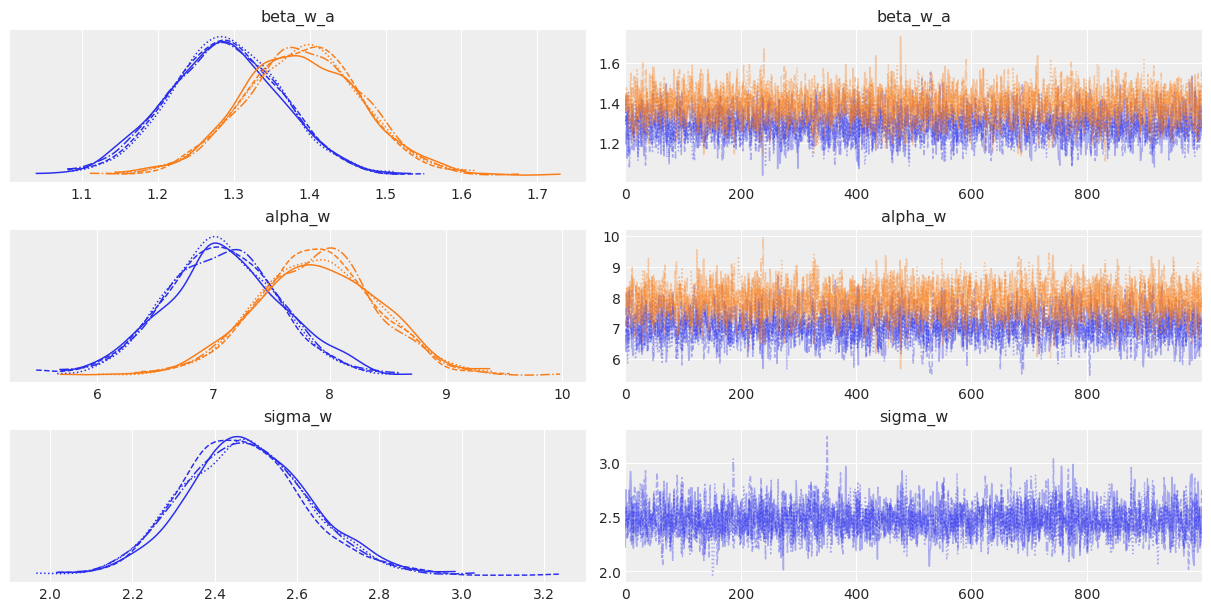

In [279]:
az.plot_trace(samples);

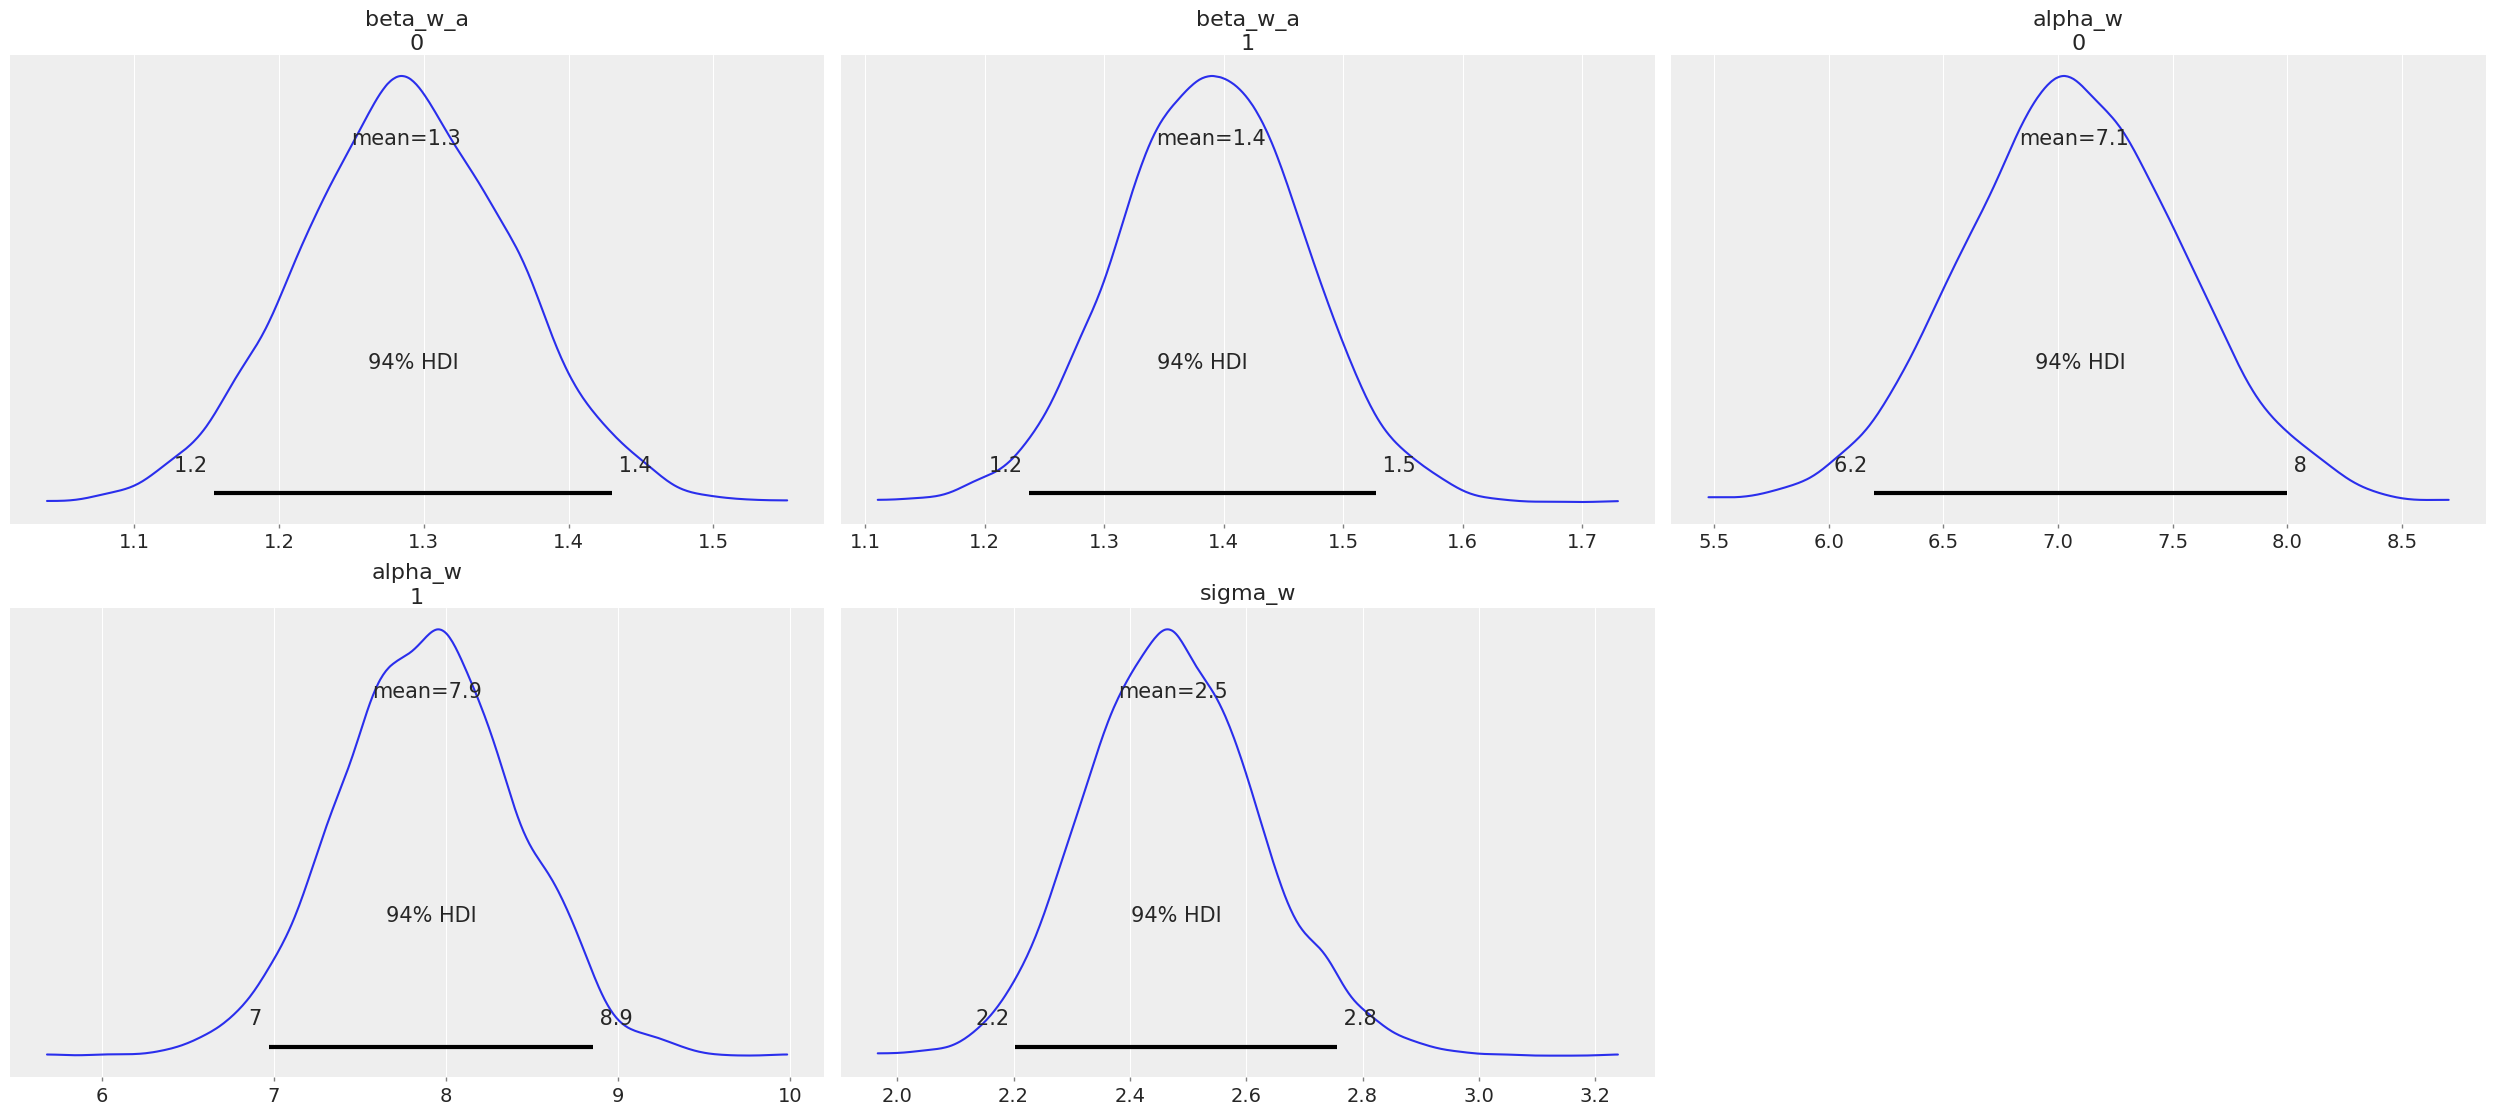

In [280]:
az.plot_posterior(samples, var_names=['beta_w_a', 'alpha_w', 'sigma_w']);

In [281]:
#Simulating lines from prior
with model:
    pm.sample_posterior_predictive(samples, extend_inferencedata=True)

Sampling: [weight]


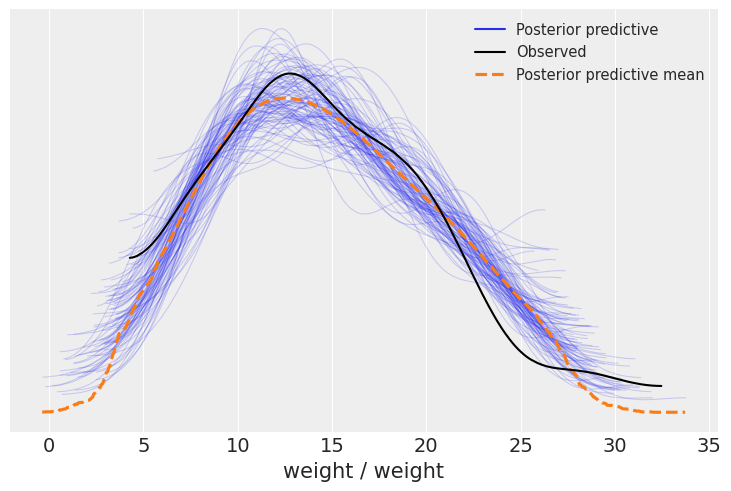

In [351]:
az.plot_ppc(samples, num_pp_samples=100);

In [283]:
az.summary(samples, var_names=['beta_w_a', 'alpha_w', 'sigma_w'], kind='stats')

mean     sd  hdi_3%  hdi_97%
beta_w_a[0]  1.288  0.073   1.155    1.430
beta_w_a[1]  1.389  0.077   1.237    1.528
alpha_w[0]   7.068  0.480   6.198    7.998
alpha_w[1]   7.892  0.515   6.971    8.857
sigma_w      2.475  0.149   2.203    2.756

In [330]:
# post = samples.posterior
# mu_w = post["alpha_w"] + post["beta_w_a"] * xr.DataArray(data['age'], dims=["obs_id"])

# _, ax = plt.subplots()

# ax.plot(
#     data['age'], mu_w.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6
# )
# ax.scatter(data['age'], samples.observed_data["weight"])
# az.plot_hdi(data['age'], samples.posterior_predictive["weight"])
# ax.set_xlabel("Predictor (Age)")
# ax.set_ylabel("Outcome (Weight)");

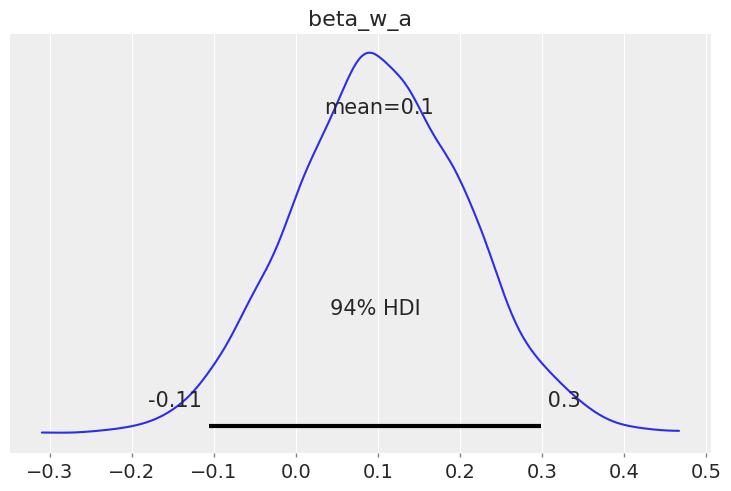

In [352]:
az.plot_posterior((samples['posterior']['beta_w_a'][:,:,1] - samples['posterior']['beta_w_a'][:,:,0]));

# 4

The data in data(Oxboys) (rethinking
package) are growth records for 26 boys measured over 9 periods. I want
you to model their growth. Specifically, model the increments in growth
from one period (Occasion in the data table) to the next. Each increment is
simply the difference between height in one occasion and height in the previous occasion. Since none of these boys shrunk during the study, all of the
growth increments are greater than zero. Estimate the posterior distribution
of these increments. Constrain the distribution so it is always positive—it
should not be possible for the model to think that boys can shrink from year
to year. Finally compute the posterior distribution of the total growth over
all 9 occasions.

In [227]:
data = pd.read_csv('../Data/Oxboys.csv', delimiter=';')
data['Subject'] = data['Subject'] - 1
data

Subject     age  height  Occasion
0          0 -1.0000   140.5         1
1          0 -0.7479   143.4         2
2          0 -0.4630   144.8         3
3          0 -0.1643   147.1         4
4          0 -0.0027   147.7         5
..       ...     ...     ...       ...
229       25 -0.0027   138.4         5
230       25  0.2466   138.9         6
231       25  0.5562   141.8         7
232       25  0.7781   142.6         8
233       25  1.0055   143.1         9

[234 rows x 4 columns]

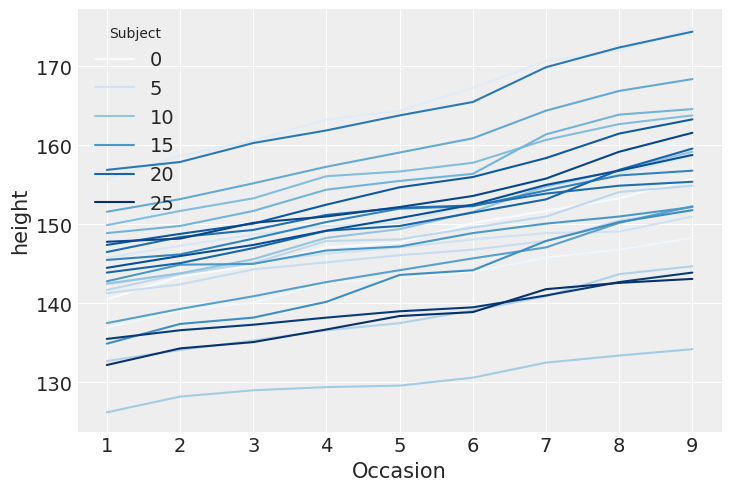

In [228]:
sns.lineplot(data=data, x='Occasion', y='height', hue='Subject', palette='Blues');

In [229]:
# data['Subject'] = pd.Categorical(data['Subject'])
# data['height'] = minmax_scale(data['height'], )

# with pm.Model() as ox_model:
#     occasions_data = pm.ConstantData(name='occasion_data', value=data['Occasion'], dims='samples')
#     height_data = pm.ConstantData(name='height_data',value=data['height'],  dims='samples')
    
#     beta_w_a = pm.TruncatedNormal('beta_w_a', mu=0, sigma=0.1, lower=0, shape = data['Subject'].cat.categories.size)
#     alpha_w = pm.Uniform('alpha_w', 0, 1, shape = data['Subject'].cat.categories.size)
#     sigma_w = pm.Uniform('sigma_w',0, 1)

#     mu_w = alpha_w[data['Subject']] + beta_w_a[data['Subject']]*occasions_data
#     height = pm.Normal('height', mu_w, sigma_w, observed=height_data, dims='samples')
    
# ox_model

In [243]:
data['Subject'] = pd.Categorical(data['Subject'])
data['height'] = minmax_scale(data['height'], )

with pm.Model() as ox_model:
    occasions_data = pm.ConstantData(name='occasion_data', value=data['Occasion'], dims='samples')
    height_data = pm.ConstantData(name='height_data',value=data['height'],  dims='samples')
    
    beta = pm.TruncatedNormal('beta', mu=0.1, sigma=0.1, lower=0)
    alpha = pm.TruncatedNormal('alpha', mu=0.2, sigma=0.1, lower=0)
    sigma = pm.TruncatedNormal('sigma', mu=0.1, sigma=0.1, lower=0)

    mu = alpha + beta*occasions_data
    height = pm.Normal('height', mu, sigma, observed=height_data, dims='samples')
    
    total_sum = pm.Deterministic('total_sum', beta*8)
    
ox_model

     beta ~ TruncatedNormal(0.1, 0.1, 0, inf)
    alpha ~ TruncatedNormal(0.2, 0.1, 0, inf)
    sigma ~ TruncatedNormal(0.1, 0.1, 0, inf)
total_sum ~ Deterministic(f(beta))
   height ~ N(f(alpha, beta), sigma)

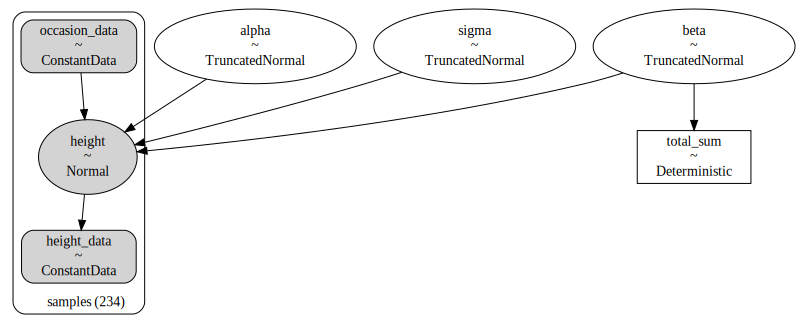

In [244]:
pm.model_to_graphviz(ox_model)

Sampling: [alpha, beta, height, sigma]


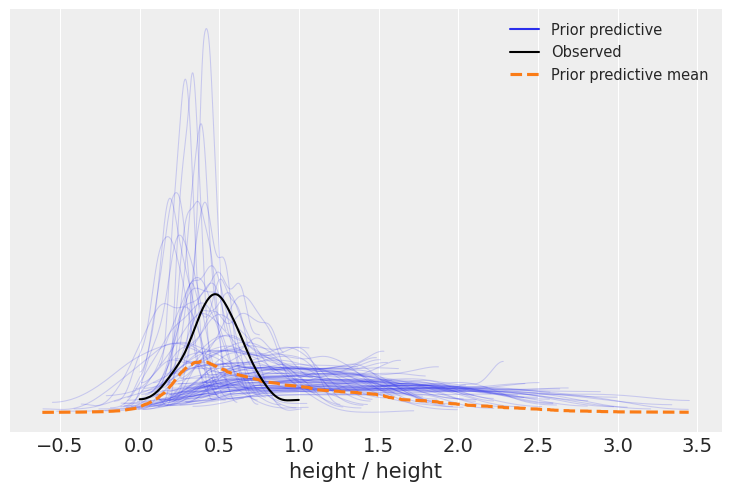

In [245]:
with ox_model:
    samples = pm.sample_prior_predictive(samples=1000)
    
az.plot_ppc(samples, group='prior', num_pp_samples=100);

In [246]:
with ox_model:
    samples = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


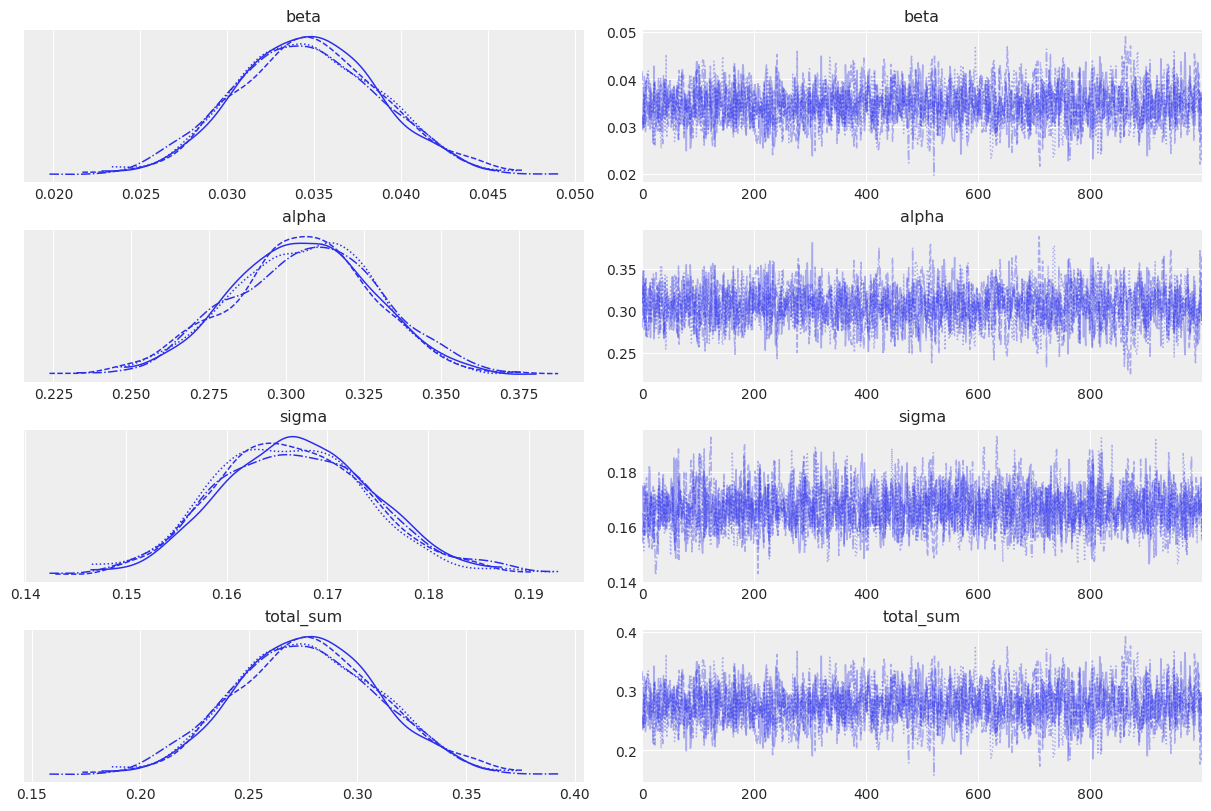

In [247]:
az.plot_trace(samples);

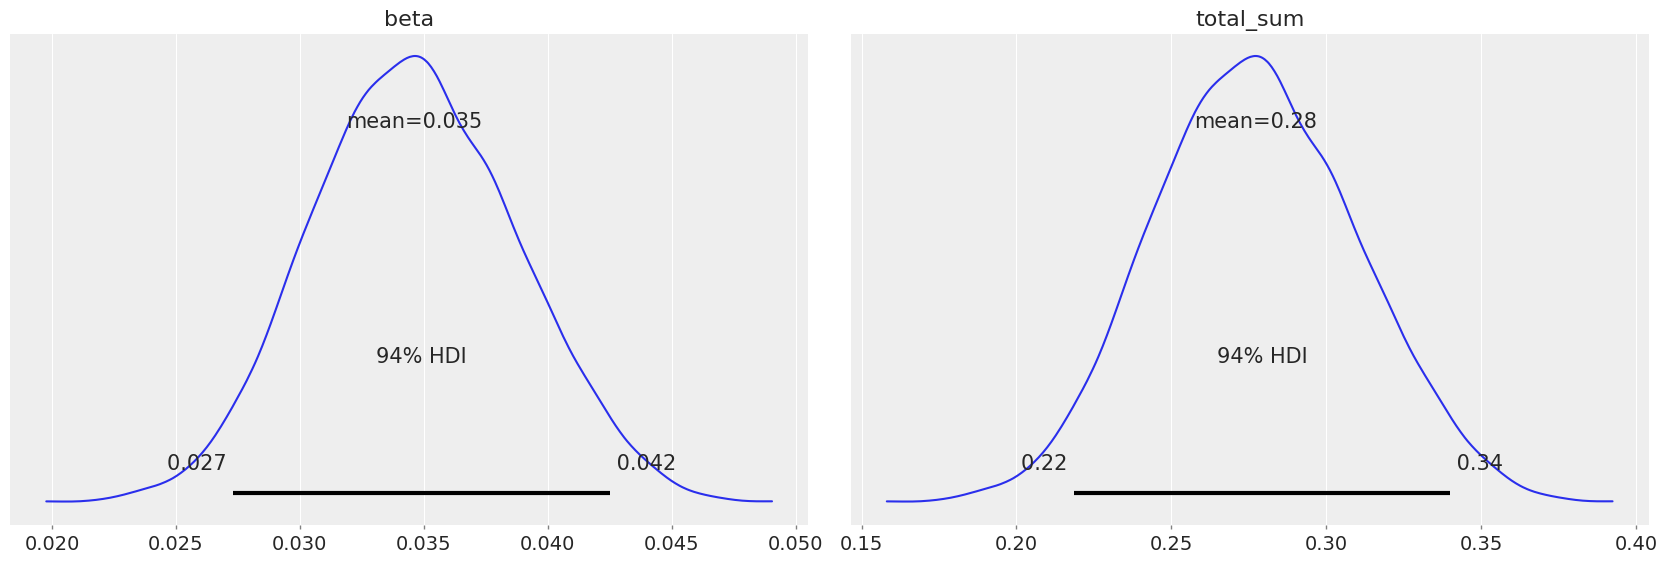

In [275]:
az.plot_posterior(samples, var_names=['beta', 'total_sum']);

In [249]:
#Simulating lines from prior
with ox_model:
    pm.sample_posterior_predictive(samples, extend_inferencedata=True)

Sampling: [height]


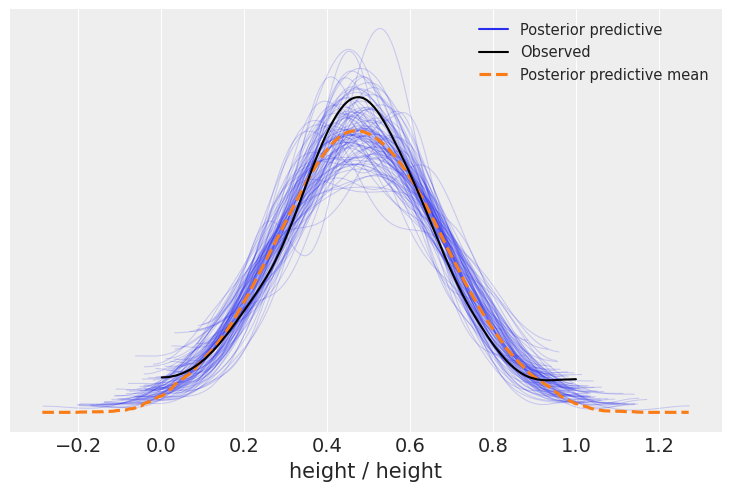

In [250]:
az.plot_ppc(samples, num_pp_samples=100);

In [254]:
az.summary(samples, var_names=['beta', 'alpha', 'sigma', 'total_sum'], kind='stats')

mean     sd  hdi_3%  hdi_97%
beta       0.035  0.004   0.027    0.042
alpha      0.306  0.023   0.263    0.349
sigma      0.167  0.008   0.152    0.181
total_sum  0.277  0.033   0.219    0.340

In [272]:
increment_sums = []
for _ in range(10000):
    increments = np.random.choice(samples['posterior']['beta'].to_numpy().flatten(), 8)
    increment_sums.append(increments.sum())

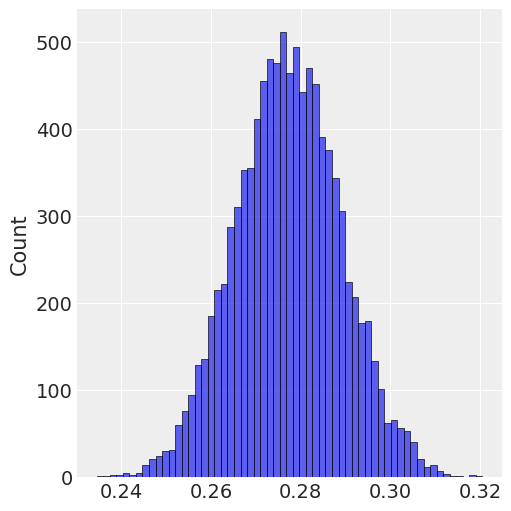

In [273]:
sns.displot(increment_sums);

In [274]:
np.mean(increment_sums)

0.27719497322769826